# Week 2: Astronomy 499 Research
### Image & Fourier Space Transformations

In [1]:
import numpy as np
import numpy.ma as ma
import scipy
import scipy.ndimage
import scipy.constants as const
from scipy import fftpack
import matplotlib.pyplot as plt
import pandas as pd

## Part 1:

In a Jupyter python notebook, create a 256x256 pixel numpy array with a single pixel with value 1 roughly in the center. 

In [2]:
def mostly_zeros(shape, nonzero_position, dtype=float, nonzero_element = 1):
    reval = np.zeros(shape, dtype=dtype)
    reval[128, 128] = nonzero_element
    return reval

image_array = mostly_zeros(shape=(256, 256), nonzero_position=(128, 128))

### Question 1a: Shifting images in *image space*
Use scipy.ndimage.shift to shift a copy of the image by a fraction of a pixel (say 0.34 in x and 0.2 in y). FFT the shifted image and the original, and divide the FFT of the shifted image by the FFT of the original. Make two images of the result: one of the amplitude, the other of the phase.

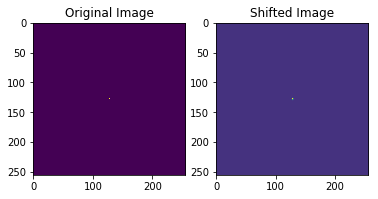

In [3]:
fig, ax = plt.subplots(1,2)

# Plot of Original Image
ax[0].imshow(image_array);
ax[0].set_title('Original Image')

# Shift of Original Image
shift1a = scipy.ndimage.shift(image_array, (0.34, 0.2), output=None, order = 3, mode='constant', cval=0.0, prefilter=True)

# plot of Shifted Image
ax[1].imshow(shift1a)
ax[1].set_title('Shifted Image');

In [4]:
#FFT shifted image
fft_shiftedimage = fftpack.fft2(shift1a)

#FFT original image
fft_originalimage = fftpack.fft2(image_array)

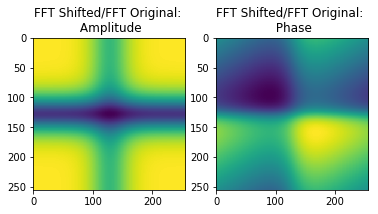

In [5]:
#FFT shifted/FFT original
fft_shifted_over_original = fft_shiftedimage/fft_originalimage
#print(fft_shifted_over_original)

fig, ax = plt.subplots(1,2)

#Image of amplitude
amplitude = np.abs(fft_shifted_over_original)
ax[0].imshow(amplitude);
ax[0].set_title('FFT Shifted/FFT Original: \n Amplitude');

#Image of phase
realvalues = fft_shifted_over_original.real
phase = np.angle(fft_shifted_over_original)
ax[1].imshow(phase);
ax[1].set_title('FFT Shifted/FFT Original: \n Phase');

### Question 1b: Shifting images in *Fourier space*
Create an analytic shift kernel in Fourier space, corresponding to the same direction and magnitude of shift from 1a. Remember, a linear shift in image space is a phase ramp in Fourier space, and you should have an idea what the values should be from 1a. Write down the equation for calculating the phase ramp for a desired linear shift in image space. FFT the original (unshifted) image, multiply by the Fourier representation of the shift kernel you have just created, and FFT back. Check that the amplitude of the peak of the new image is roughly the same as the peak of the shifted image in 1a. What sort of imaging artifacts do you see?

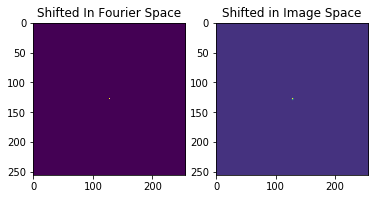

In [6]:
fig, ax = plt.subplots(1,2)

dimension = 256
dx = 0.34
dy = 0.2
phaseramp = np.exp(2 * np.pi * ((dx/dimension)+(dy/dimension)))

#FFT Original Image
fft_originalimage1b = fftpack.fft(image_array)

#Multiply by Fourier representation of shift
fft_original1b_shift = fft_originalimage1b * phaseramp

#FFT Back (Fourier Space)
fft_originalshift_back = fftpack.ifft(fft_original1b_shift)
fftback = np.abs(fft_originalshift_back)
ax[0].imshow(fftback);
ax[0].set_title('Shifted In Fourier Space');

#FFT in Image Space
ax[1].imshow(shift1a)
ax[1].set_title('Shifted in Image Space');


## Part 2: FFTs of images

### Question 2a: Aliasing
Create a 256x256 pixel numpy array containing a 2D gaussian at the center, with a width roughly 1/10 the size of the full image (it should look compact). Take the FFT of a copy, and make an image of the real part of the result. If it oscillates, you need to apply an FFT shift first. Use this image as a reference to create the analytic Fourier transform of your gaussian directly in Fourier space. FFT the new Fourier analytic gaussian back to image space, and subtract the result from the original. Make an image of the residual.

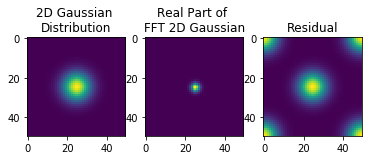

In [7]:
# Create 2D Gaussian Function
def gaussian2d (x, y, xcenter = 128, ycenter = 128, sigmax = 25.6, sigmay = 25.6):
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = (1/(2 * np.pi * sigmax * sigmay)) * np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    return gaussian

# X, Y & Gaussian Values
x = np.linspace(0, 255)
y = np.linspace(0, 255)
x, y = np.meshgrid(x, y)
gaus2d = gaussian2d(x, y)

fig, ax = plt.subplots(1,3)

# Plot of Gaussian Distribution [Plot #1]
ax[0].imshow(gaus2d)
ax[0].set_title('2D Gaussian \nDistribution');

# FFT of a copy of the Gaussian Distribution
gaus2d_copy = np.copy(gaus2d)
fft_gaus2d = fftpack.ifftshift(fftpack.ifft2(gaus2d_copy))

# Plot of Real Part of Copied Gaussian Distribution
ax[1].imshow(np.abs(fft_gaus2d))
ax[1].set_title('Real Part of \nFFT 2D Gaussian');

# Analytic Fourier Transform of Gaussian
def analyticfft(gaus):
    afft = fftpack.ifftshift(fftpack.fft2(gaus))
    return afft

analytic_gaus = analyticfft(gaus2d_copy)

# FFT Analytic Fourier Transform of Gaussian Back To Image
afftgaus_2image = fftpack.ifftshift(fftpack.ifft2(analytic_gaus))

# Subtract FFT Analytic from Original
subtraction = np.abs(gaus2d - afftgaus_2image)

# Plot of the Residual
ax[2].imshow(subtraction)
ax[2].set_title('Residual');


### Question 2b: Masks
Create a new 256x256 numpy array that zeroes out roughly 1/10th of the pixels. Create a new gaussian image with small amplitude noise and a small DC offset, and apply the mask. FFT the masked image, and compare to the unmasked image of 2a. Now, go back and fill the masked regions of your noisy gaussian image with comparable noise with the same DC offset. FFT the filled image. Compare the filled and unfilled FFT'd images.

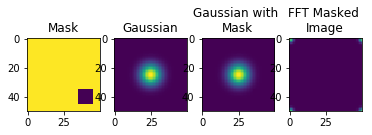

In [8]:
fig, ax = plt.subplots(1,4)

zeromask = np.ones((50,50))
zeromask[35:45,35:45] = 0

# Zero mask
ax[0].imshow(zeromask)
ax[0].set_title('Mask');

# New Gaussian
newgaus = gaussian2d(x, y)
ax[1].imshow(newgaus)
ax[1].set_title('Gaussian');

# Plot of New Gaussian with Mask
maskedgaussian = newgaus * zeromask
ax[2].imshow(maskedgaussian)
ax[2].set_title('Gaussian with \nMask');

# FFT Masked Image
fft_maskedgaussian = np.abs(fftpack.fft2(maskedgaussian))
ax[3].imshow(fft_maskedgaussian)
ax[3].set_title('FFT Masked \nImage');

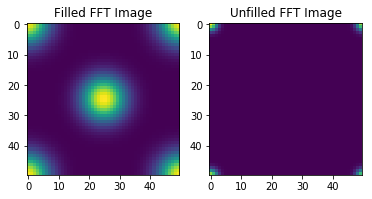

In [9]:
# Comparison of Filled and Unfilled FFT Images
fig, ax = plt.subplots(1, 2)

# Filled FFT Image
filled_fftimage = subtraction
ax[0].imshow(filled_fftimage)
ax[0].set_title('Filled FFT Image');

# Unfilled FFT Image
unfilled_fftimage = fft_maskedgaussian
ax[1].imshow(unfilled_fftimage)
ax[1].set_title('Unfilled FFT Image');